# Init

In [ ]:
import json
import os
from pathlib import Path

import torch
from PIL import Image
from mmengine.config import Config
from diffusers.utils import check_min_version
from diffusers.loaders.peft import _SET_ADAPTER_SCALE_FN_MAPPING
from utils.bbox_visualization import bbox_visualization

# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
check_min_version("0.31.0.dev0")

def load_config(yaml_path: str):
    return Config.fromfile(yaml_path)

def seed_everything(seed: int):
    import random, numpy as np
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def initialize_pipeline(config, fuse_lora_list=[], use_rds=False):
    from diffusers import FluxTransformer2DModel
    if use_rds:
        from src.models.model_flux_HybridLayout_rds import HybridLayoutFluxTransformer2DModel, hack_model_attn_w_mask
        from src.pipeline.pipeline_flux_HybridLayout_rds import HybridLayoutFluxPipeline, HybridLayoutFluxPipelineCfg
    else:
        from src.models.model_flux_HybridLayout import HybridLayoutFluxTransformer2DModel, hack_model_attn_w_mask
        from src.pipeline.pipeline_flux_HybridLayout import HybridLayoutFluxPipeline, HybridLayoutFluxPipelineCfg
    from safetensors.torch import load_file
    from diffusers.configuration_utils import FrozenDict

    # 1. Original Transformer
    transformer_orig = FluxTransformer2DModel.from_pretrained(
        config.transformer_varient if hasattr(config, "transformer_varient") else config['pretrained_model_name_or_path'],
        subfolder="" if hasattr(config, "transformer_varient") else "transformer", 
        revision=config.get('revision', None), 
        variant=config.get('variant', None), 
        torch_dtype=torch.bfloat16,
        strict=False,
        cache_dir=config.get('cache_dir', None)
    )

    # 2. Custom Transformer
    mmdit_config = dict(transformer_orig.config)
    mmdit_config["_class_name"] = "CustomSD3Transformer2DModel"
    mmdit_config["max_layer_num"] = config['max_layer_num']
    mmdit_config = FrozenDict(mmdit_config)

    transformer = HybridLayoutFluxTransformer2DModel.from_config(mmdit_config).to(dtype=torch.bfloat16)
    if use_rds:
        transformer.scale_factor = config['scale_factor']
    missing_keys, unexpected_keys = transformer.load_state_dict(transformer_orig.state_dict(), strict=False)
    if missing_keys:
        print(f"[WARNING] Missing keys: {missing_keys}", flush=True)
    if unexpected_keys:
        print(f"[WARNING] Unexpected keys: {unexpected_keys}", flush=True)
    print("[INFO] Successfully loaded Transformer weights.", flush=True)

    # Load LoRA weights
    if hasattr(config, "pretrained_lora_dir"):
        lora_state_dict = HybridLayoutFluxPipeline.lora_state_dict(config.pretrained_lora_dir)
        HybridLayoutFluxPipeline.load_lora_into_transformer(lora_state_dict, None, transformer)
        transformer.fuse_lora(safe_fusing=True)
        transformer.unload_lora() # don't forget to unload the lora params
        print("[INFO] Successfully loaded and fused LoRA weights.", flush=True)

    # Load layer_pe weights
    layer_pe_path = os.path.join(config['ckpt_dir'], "layer_pe.pth")
    if os.path.exists(layer_pe_path):
        print("[INFO] Loading layer_pe weights...", flush=True)
        layer_pe = torch.load(layer_pe_path)
        missing_keys, unexpected_keys = transformer.load_state_dict(layer_pe, strict=False)
        if unexpected_keys:
            print(f"[WARNING] Unexpected keys: {unexpected_keys}", flush=True)
        print("[INFO] Successfully loaded layer_pe weights.", flush=True)
    else:
        print(f"[WARNING] layer_pe weights file not found: {layer_pe_path}", flush=True)

    if config.get("use_mask", False):
        print(f"[INFO] using mask type: {config['attn_type']}.\n")
        hack_model_attn_w_mask(transformer, attn_type=config["attn_type"])

    pipeline_type = HybridLayoutFluxPipelineCfg if config['use_true_cfg'] else HybridLayoutFluxPipeline
    pipeline = pipeline_type.from_pretrained(
        config['pretrained_model_name_or_path'],
        transformer=transformer,
        revision=config.get('revision', None),
        variant=config.get('variant', None),
        torch_dtype=torch.bfloat16,
        cache_dir=config.get('cache_dir', None),
    ).to(torch.device("cuda"))

    pipeline.load_lora_weights(config['ckpt_dir'], adapter_name="layer")

    _SET_ADAPTER_SCALE_FN_MAPPING["HybridLayoutFluxTransformer2DModel"] = _SET_ADAPTER_SCALE_FN_MAPPING["FluxTransformer2DModel"]
    # for lora_name in fuse_lora_list:
    #     lora_info = lora_mapping[lora_name]
    #     if "weight_name" in lora_info:
    #         pipeline.load_lora_weights(lora_info["url"], weight_name=lora_info["weight_name"], adapter_name=lora_name)
    #     else:
    #         pipeline.load_lora_weights(lora_info["url"], adapter_name=lora_name)

    adapter_names = ["layer"] + fuse_lora_list
    pipeline.set_adapters(adapter_names, adapter_weights=[1.0]*len(adapter_names))

    print("[INFO] Successfully loaded pipeline LoRA weights.", flush=True)

    # use for memory saving
    # pipeline.enable_model_cpu_offload()
    # print("[INFO] CPU offloading successfully.", flush=True)

    return pipeline

def scale_and_align_bboxes(bboxes, scale=1024, alignment=16):
    import torch
    bboxes = torch.tensor(bboxes, dtype=torch.float32) * scale
    bboxes = (torch.round(bboxes / alignment) * alignment).int().tolist()
    return bboxes


/opt/miniconda/envs/hybrid_layout/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Test

## Init model

In [2]:
seed = 42
use_rds = False
config_path = "./configs/inference_flux_aes_ratio_1.yaml"
cfg = load_config(config_path)
pipe = initialize_pipeline(cfg)
generator = torch.Generator(device="cuda").manual_seed(seed)

Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 92.74it/s]


[WARNING] 缺失的键：['layer_pe']
[INFO] 成功加载 Transformer 权重。
[INFO] 加载 layer_pe 权重...
[INFO] 成功加载 layer_pe 权重。
[INFO] using mask type: interact.



Loading pipeline components...: 100%|██████████| 7/7 [00:10<00:00,  1.52s/it]


[INFO] 成功加载 pipeline 的 LoRA 权重。


## setting

In [3]:
from datetime import datetime

def convert_json_format(json_str, filename="test1.png"):
    data = json.loads(json_str)
    base_prompt = data["caption"]

    prompt_list = [f"{base_prompt}"]
    boxes = []

    for anno in data["annos"]:
        caption = anno["caption"]
        bbox = anno["bbox"]
        prompt_list.append(caption)
        boxes.append(bbox)

    result = [{
        "prompt": prompt_list,
        "boxes": boxes,
        "filename": filename
    }]

    return result

def convert_bboxes_to_16_alignment(bboxes):
    bboxes_aligned = []
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        x1 = round(x1 / 16) * 16
        y1 = round(y1 / 16) * 16
        x2 = round(x2 / 16) * 16
        y2 = round(y2 / 16) * 16
        bboxes_aligned.append([x1, y1, x2, y2])
    return bboxes_aligned

def test(test_json_data, config_path, output_dir, img_w=1024, img_h=1024, steps=50, use_rds=False):
    seed_everything(seed)
    cfg = load_config(config_path)
    out_dir = Path(output_dir)
    img_dir = out_dir / "images"
    vis_dir = out_dir / "images_with_layout"
    img_dir.mkdir(parents=True, exist_ok=True)
    vis_dir.mkdir(parents=True, exist_ok=True)

    tasks = json.loads(test_json_data)

    for idx, task in enumerate(tasks):
        prompt = task["prompt"]
        boxes = task["boxes"]
        boxes = convert_bboxes_to_16_alignment(boxes)

        print(f"prompt: {prompt}\n")
        print(f"boxes: {boxes}\n")

        fname = task.get("filename", f"test_{idx:04d}.png")
        out_file = img_dir / fname
        if out_file.exists():
            continue
        
        if use_rds:
            images, _, _, _, _ = pipe(
                prompt=prompt,
                validation_box=boxes,
                height=img_h,
                width=img_w,
                num_layers=len(boxes),
                num_inference_steps=steps,
                generator=generator,
                scale_factor=cfg['scale_factor'],
            )
        else:
            images, _, _ = pipe(
                prompt=prompt,
                validation_box=boxes,
                height=img_h,
                width=img_w,
                num_layers=len(boxes),
                num_inference_steps=steps,
                generator=generator,
            )

        image = images.images[0]
        image.save(out_file)

        white = Image.new("RGB", (img_w, img_h), "white")
        labels = [f"{i+1}" for i in range(len(boxes) - 1)]
        vis = bbox_visualization(white, {"boxes": boxes[1:], "labels": labels})
        merged = Image.new("RGB", (img_w * 2, img_h))
        merged.paste(vis, (0, 0))
        merged.paste(bbox_visualization(image, {"boxes": boxes[1:], "labels": labels}), (img_w, 0))
        merged.save(vis_dir / fname)

        merged.show()


The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["rainy street view outside, adding a warm and inviting atmosphere. soft, natural lighting highlights the textures of the flowers, the cat's fur, and the metallic shine of the vase."]


prompt: ['A cozy indoor scene with a beautiful bouquet of soft pink and peach roses arranged in an ornate, reflective golden vase. Beside the vase sits a fluffy, blue-eyed Ragdoll cat, looking curious and elegant. On the wooden table in front of them, there is a cup of cappuccino with latte art and steam rising from it. The background includes a window showing a blurry, rainy street view outside, adding a warm and inviting atmosphere. Soft, natural lighting highlights the textures of the flowers, the cat’s fur, and the metallic shine of the vase.', 'a beautiful bouquet of soft pink and peach roses arranged in an ornate, reflective golden vase', 'a fluffy, blue-eyed Ragdoll cat, looking curious and elegant', 'a cup of cappuccino with latte art and steam rising from it']

boxes: [[0, 0, 1024, 1024], [192, 32, 816, 752], [640, 208, 1024, 1008], [144, 720, 400, 992]]



100%|██████████| 28/28 [01:14<00:00,  2.66s/it]


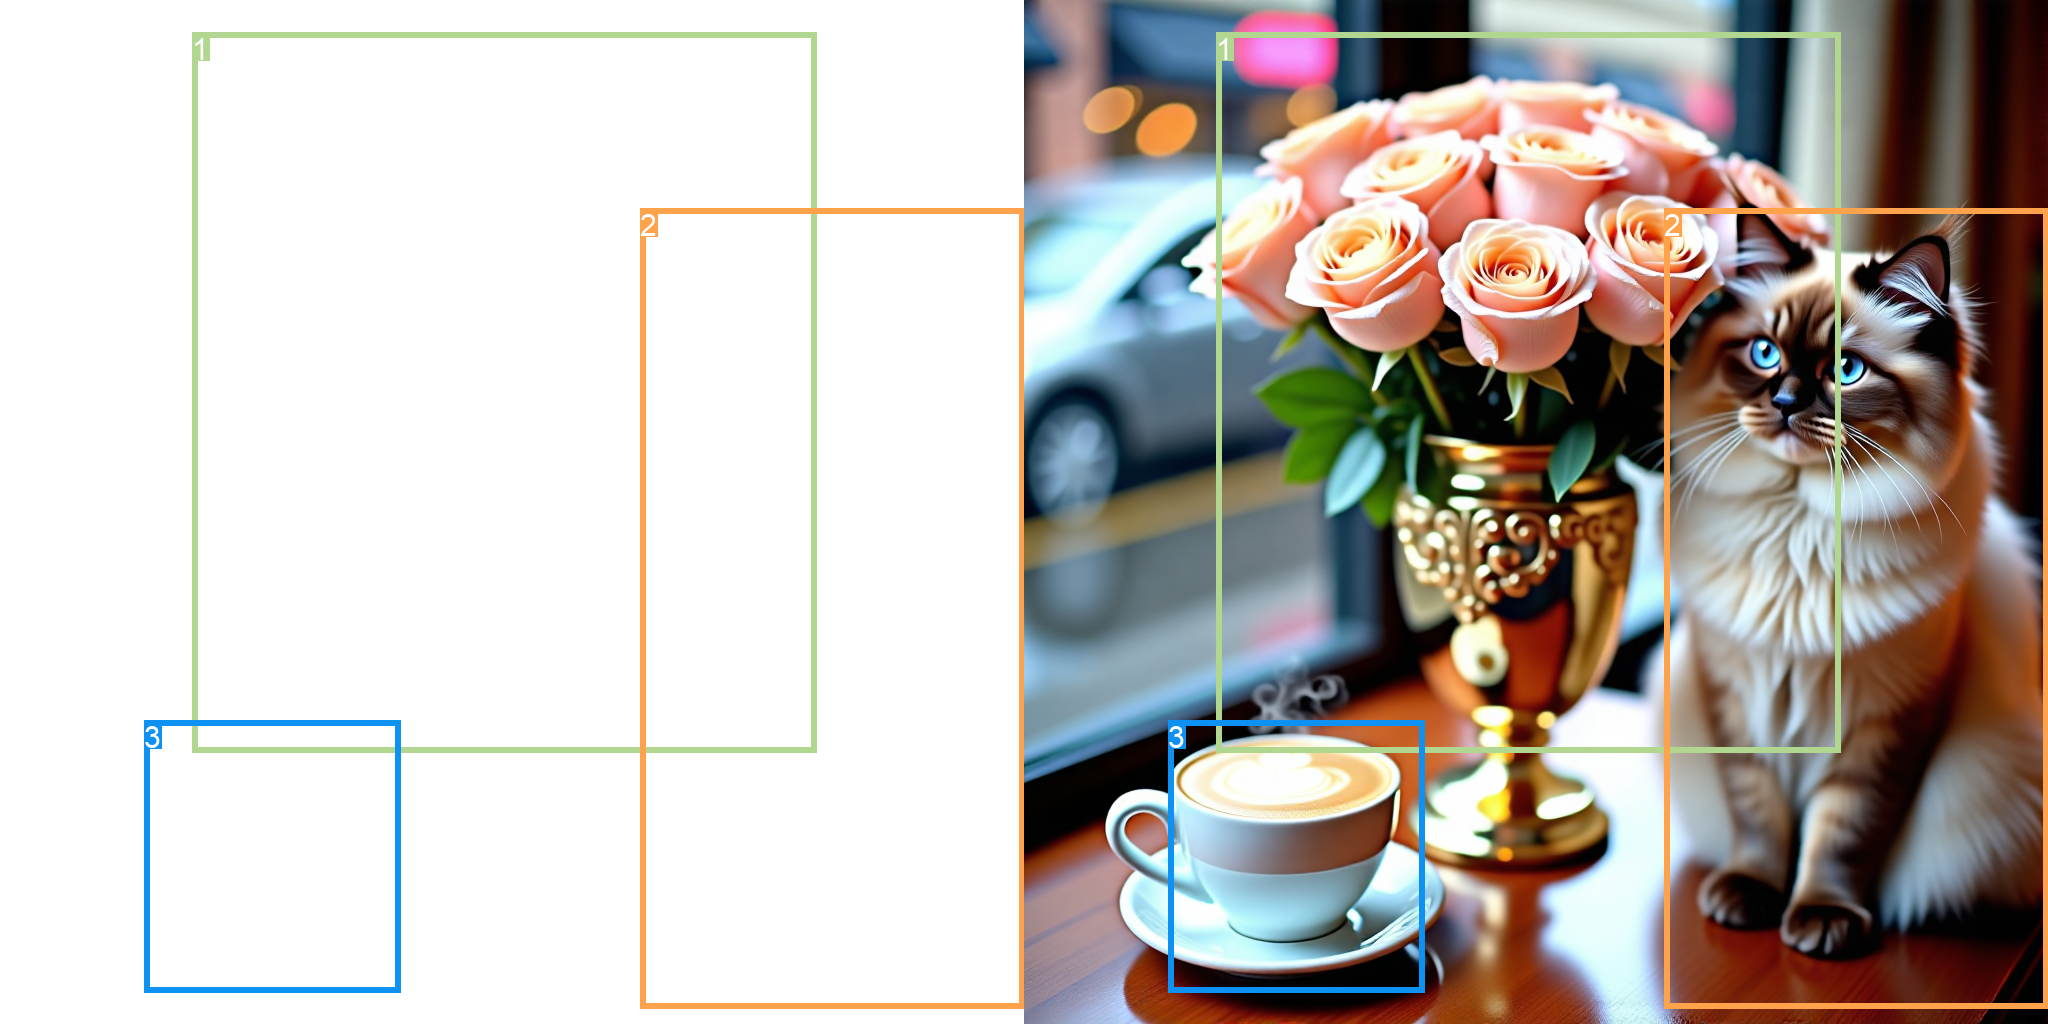

In [ ]:
date_now = datetime.now().strftime("%Y%m%d_%H%M%S")
test_json_data = '''
[
    {
        "prompt": [
            "A cozy indoor scene with a beautiful bouquet of soft pink and peach roses arranged in an ornate, reflective golden vase. Beside the vase sits a fluffy, blue-eyed Ragdoll cat, looking curious and elegant. On the wooden table in front of them, there is a cup of cappuccino with latte art and steam rising from it. The background includes a window showing a blurry, rainy street view outside, adding a warm and inviting atmosphere. Soft, natural lighting highlights the textures of the flowers, the cat’s fur, and the metallic shine of the vase.",
            "a beautiful bouquet of soft pink and peach roses arranged in an ornate, reflective golden vase",
            "a fluffy, blue-eyed Ragdoll cat, looking curious and elegant",
            "a cup of cappuccino with latte art and steam rising from it"
        ],
        "boxes": [
            [0, 0, 1024, 1024],
            [192, 25, 819, 857],
            [646, 204, 1022, 1015],
            [151, 725, 405, 985]
        ],
        "filename": "test2.png"
    }
]
'''
test(
    test_json_data,
    config_path=config_path,
    output_dir=f"./results/{date_now}",
    img_w=1024, img_h=1024, steps=50, use_rds=use_rds
)


The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', while a graceful deer with white spots and large antlers stands nearby, looking at them. the entire scene is set in a peaceful winter wonderland, surrounded by snow - covered trees and bathed in the colorful glow of the aurora borealis, evoking a sense of warmth, wonder, and holiday magic. high detail, cinematic lighting, enchanting atmosphere.']


prompt: ['A cozy wooden cabin in the snowy forest, warmly lit from within, under a magical sky filled with vibrant northern lights in shades of green, purple, and blue. In the foreground, a friendly snowman with a top hat and carrot nose stands beside a small child dressed in a red winter coat and hat, black pants, and boots. The child gently touches the snowman’s arm, while a graceful deer with white spots and large antlers stands nearby, looking at them. The entire scene is set in a peaceful winter wonderland, surrounded by snow-covered trees and bathed in the colorful glow of the aurora borealis, evoking a sense of warmth, wonder, and holiday magic. High detail, cinematic lighting, enchanting atmosphere.', 'A cozy wooden cabin', 'a small child', 'a graceful deer', 'a friendly snowman']

boxes: [[0, 0, 1024, 1024], [288, 208, 848, 704], [512, 592, 704, 960], [96, 512, 448, 944], [688, 560, 960, 912]]



100%|██████████| 28/28 [01:02<00:00,  2.24s/it]


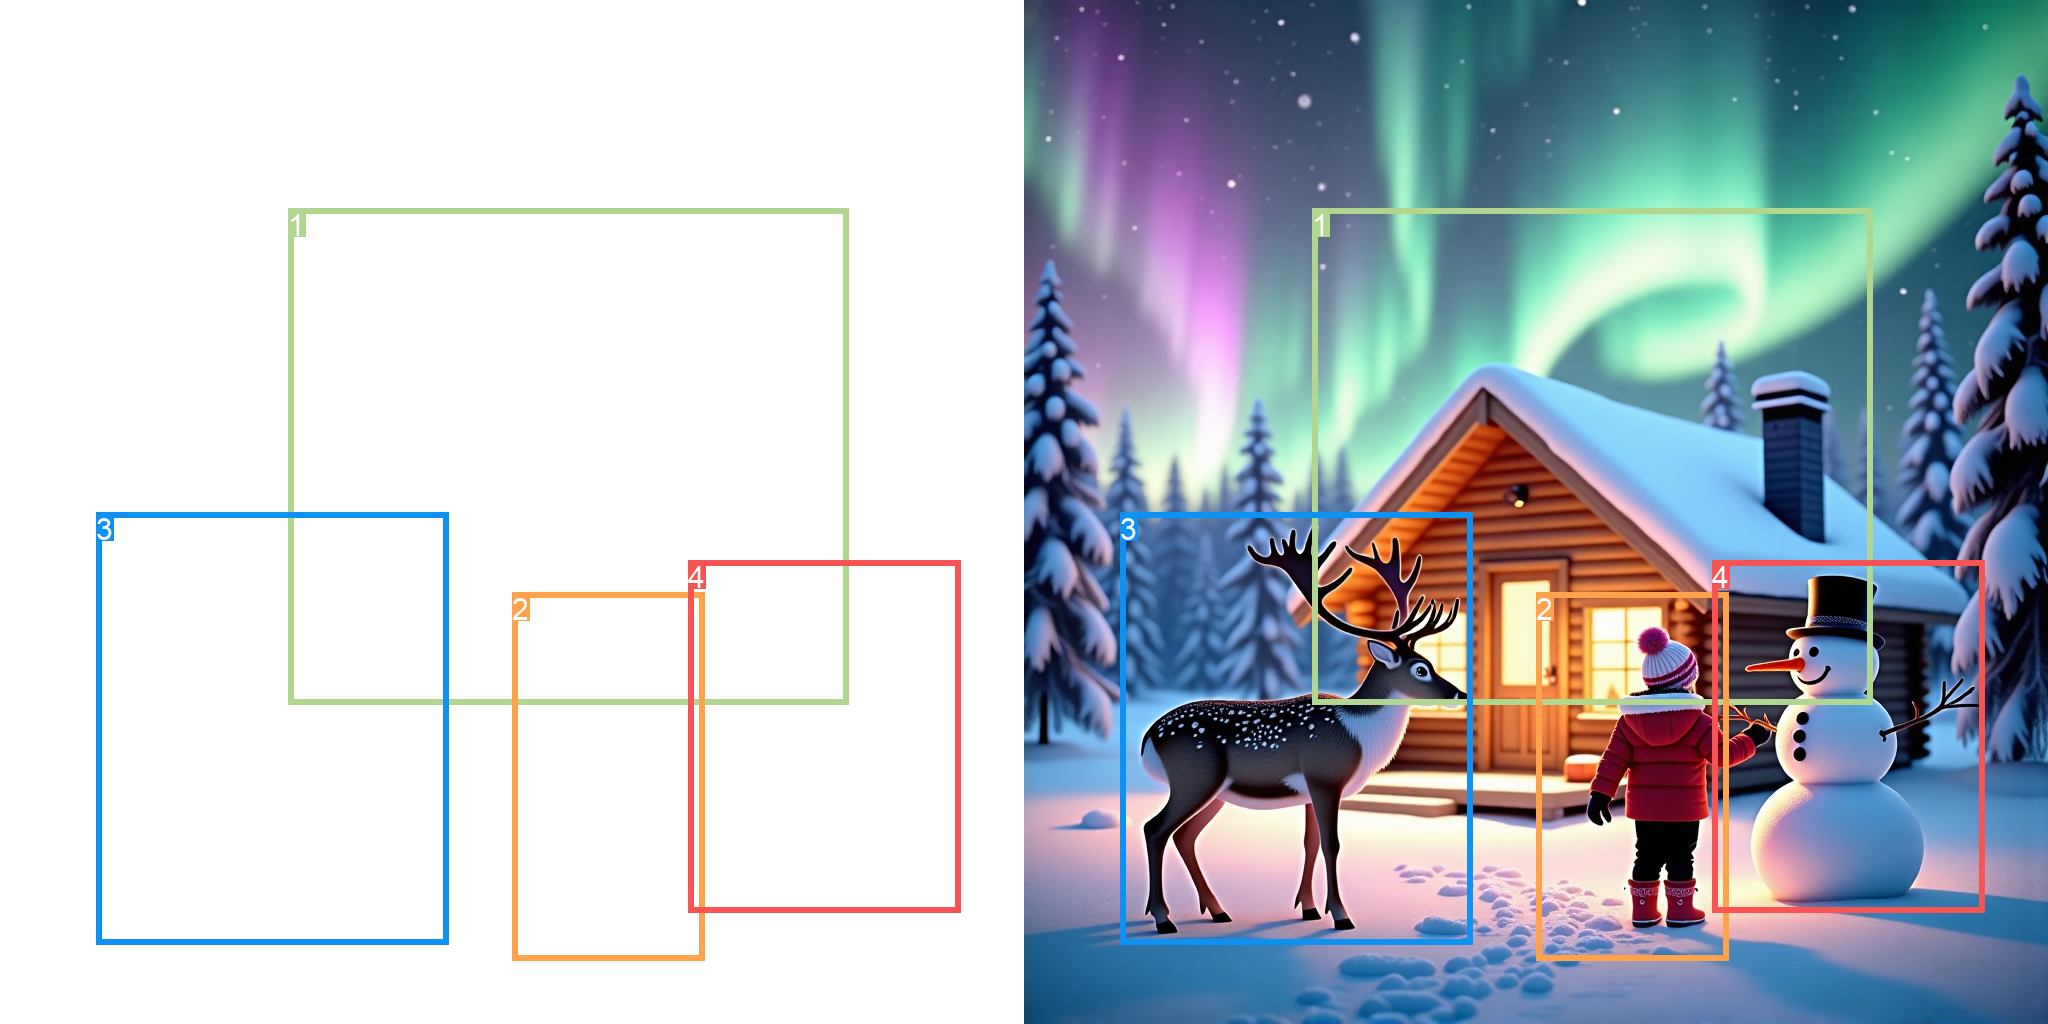

In [9]:
date_now = datetime.now().strftime("%Y%m%d_%H%M%S")
test_json_data = '''
[
    {
        "prompt": [
            "A cozy wooden cabin in the snowy forest, warmly lit from within, under a magical sky filled with vibrant northern lights in shades of green, purple, and blue. In the foreground, a friendly snowman with a top hat and carrot nose stands beside a small child dressed in a red winter coat and hat, black pants, and boots. The child gently touches the snowman’s arm, while a graceful deer with white spots and large antlers stands nearby, looking at them. The entire scene is set in a peaceful winter wonderland, surrounded by snow-covered trees and bathed in the colorful glow of the aurora borealis, evoking a sense of warmth, wonder, and holiday magic. High detail, cinematic lighting, enchanting atmosphere.",
            "A cozy wooden cabin",
            "a small child",
            "a graceful deer",
            "a friendly snowman"
        ],
        "boxes": [
            [0, 0, 1024, 1024],
            [295, 209, 853, 704],
            [514, 590, 706, 959],
            [94, 517, 447, 939],
            [686, 555, 954, 913]
        ],
        "filename": "test3.png"
    }
]
'''
test(
    test_json_data,
    config_path=config_path,
    output_dir=f"./results/{date_now}",
    img_w=1024, img_h=1024, steps=28, use_rds=use_rds
)
